## 데이터  
- CITYSCAPES 데이터셋  
- aachen (174), bochum (96), bremen (316), cologne (154), darmstadt (85), hamburg (248), hanover (196), strasbourg (365), zurich (122)  
- **Strasbourg** 지역 대상으로 수집된 365 개의 샘플을 사용해 학습
- **Frankfurt** 지역 대상으로 수집된 267 개의 샘플을 사용해 검증
- **Berlin** 지역 대상으로 수집된 544 개의 샘플을 사용해 평가

In [1]:
import os, time
from collections import namedtuple
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
import torchvision as tv

import monai

import numpy as np

import matplotlib.pyplot as plt

In [2]:
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

In [3]:
#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

print(len(labels))

35


In [4]:
RANDOM_SEED = 42
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 4
NUM_CLASS   = 2
EPOCHS      = 10

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#ROOT_PATH = 'C:/Users/bkk11/Desktop/DATA/CITYSCAPES'
ROOT_PATH = 'C:/Users/BEGAS_15/Desktop/DATA/CITYSCAPES'
MODEL_SAVE = True
if MODEL_SAVE: MODEL_SAVE_PATH = './FCN.pth'
INPUT_PATH = os.path.join(ROOT_PATH, 'leftImg8bit')
LABEL_PATH = os.path.join(ROOT_PATH, 'gtFine')

print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
print(f'torch.cuda.get_device_name(0): {torch.cuda.get_device_name(0)}')
print(f'torch.version.cuda: {torch.version.cuda}')
print(f'torch.cuda.device_count(): {torch.cuda.device_count()}')
print()
print(DEVICE)
print(INPUT_PATH)
print(LABEL_PATH)

torch.cuda.is_available(): True
torch.cuda.get_device_name(0): NVIDIA GeForce GTX 1650
torch.version.cuda: 11.7
torch.cuda.device_count(): 1

cuda
C:/Users/BEGAS_15/Desktop/DATA/CITYSCAPES\leftImg8bit
C:/Users/BEGAS_15/Desktop/DATA/CITYSCAPES\gtFine


In [5]:
INPUT_PATH_train = sorted(os.listdir(os.path.join(INPUT_PATH, 'train', 'strasbourg')))
LABEL_PATH_train = sorted([x for x in os.listdir(os.path.join(LABEL_PATH, 'train', 'strasbourg')) if 'labelIds' in x])

INPUT_PATH_val = sorted(os.listdir(os.path.join(INPUT_PATH, 'val', 'frankfurt')))
LABEL_PATH_val = sorted([x for x in os.listdir(os.path.join(LABEL_PATH, 'val', 'frankfurt')) if 'labelIds' in x])

INPUT_PATH_test = sorted(os.listdir(os.path.join(INPUT_PATH, 'test', 'berlin')))
LABEL_PATH_test = sorted([x for x in os.listdir(os.path.join(LABEL_PATH, 'test', 'berlin')) if 'labelIds' in x])

print(len(INPUT_PATH_train), INPUT_PATH_train[: 1], LABEL_PATH_train[: 1])
print(len(INPUT_PATH_val  ), INPUT_PATH_val[  : 1], LABEL_PATH_val[  : 1])
print(len(INPUT_PATH_test ), INPUT_PATH_test[ : 1], LABEL_PATH_test[ : 1])

365 ['strasbourg_000000_000065_leftImg8bit.png'] ['strasbourg_000000_000065_gtFine_labelIds.png']
267 ['frankfurt_000000_000294_leftImg8bit.png'] ['frankfurt_000000_000294_gtFine_labelIds.png']
544 ['berlin_000000_000019_leftImg8bit.png'] ['berlin_000000_000019_gtFine_labelIds.png']


In [6]:
X_train = list(map(lambda x: os.path.join(INPUT_PATH, 'train', 'strasbourg', x), INPUT_PATH_train))
y_train = list(map(lambda x: os.path.join(LABEL_PATH, 'train', 'strasbourg', x), LABEL_PATH_train))

X_val = list(map(lambda x: os.path.join(INPUT_PATH, 'val', 'frankfurt', x), INPUT_PATH_val))
y_val = list(map(lambda x: os.path.join(LABEL_PATH, 'val', 'frankfurt', x), LABEL_PATH_val))

X_test = list(map(lambda x: os.path.join(INPUT_PATH, 'test', 'berlin', x), INPUT_PATH_test))
y_test = list(map(lambda x: os.path.join(LABEL_PATH, 'test', 'berlin', x), LABEL_PATH_test))

print(X_train[: 1], y_train[: 1])
print(X_val[  : 1], y_val[  : 1])
print(X_test[ : 1], y_test[ : 1])

['C:/Users/BEGAS_15/Desktop/DATA/CITYSCAPES\\leftImg8bit\\train\\strasbourg\\strasbourg_000000_000065_leftImg8bit.png'] ['C:/Users/BEGAS_15/Desktop/DATA/CITYSCAPES\\gtFine\\train\\strasbourg\\strasbourg_000000_000065_gtFine_labelIds.png']
['C:/Users/BEGAS_15/Desktop/DATA/CITYSCAPES\\leftImg8bit\\val\\frankfurt\\frankfurt_000000_000294_leftImg8bit.png'] ['C:/Users/BEGAS_15/Desktop/DATA/CITYSCAPES\\gtFine\\val\\frankfurt\\frankfurt_000000_000294_gtFine_labelIds.png']
['C:/Users/BEGAS_15/Desktop/DATA/CITYSCAPES\\leftImg8bit\\test\\berlin\\berlin_000000_000019_leftImg8bit.png'] ['C:/Users/BEGAS_15/Desktop/DATA/CITYSCAPES\\gtFine\\test\\berlin\\berlin_000000_000019_gtFine_labelIds.png']


In [7]:
samplex = tv.io.read_image(X_train[0])
sampley = tv.io.read_image(y_train[0])

print(samplex.shape, samplex.dtype)
print(sampley.shape, sampley.dtype, np.unique(sampley))

torch.Size([3, 1024, 2048]) torch.uint8
torch.Size([1, 1024, 2048]) torch.uint8 [ 0  1  2  3  4  6  7  8 11 17 20 21 22 23 26 33]


In [8]:
X_train_trans = tv.models.VGG16_Weights.IMAGENET1K_FEATURES.transforms()
y_train_trans = tv.transforms.Compose([
    tv.transforms.Resize(size = 256, interpolation = tv.transforms.InterpolationMode.NEAREST),
    tv.transforms.CenterCrop(size = IMG_SIZE)
])

X_val_trans = tv.models.VGG16_Weights.IMAGENET1K_FEATURES.transforms()
y_val_trans = tv.transforms.Compose([
    tv.transforms.Resize(size = 256, interpolation = tv.transforms.InterpolationMode.NEAREST),
    tv.transforms.CenterCrop(size = IMG_SIZE)
])

print(X_train_trans)
print(y_train_trans)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.48235, 0.45882, 0.40784]
    std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098]
    interpolation=InterpolationMode.BILINEAR
)
Compose(
    Resize(size=256, interpolation=nearest, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
)


In [9]:
def OneHotEncoding(labels, num_classes:int):
    shape = labels.shape
    label_oh = torch.zeros(*shape) 
    for cnt, i in enumerate(sorted(np.unique(labels))):
        i_mask = torch.where(labels == i, cnt, 0)
        label_oh.masked_fill_(i_mask, cnt)
    label_oh = F.one_hot(label_oh.to(torch.int64), num_classes = num_classes)
    label_oh = label_oh.permute(2, 0, 1).to(torch.float)
    return label_oh


class DataLoader(torch.utils.data.Dataset):
    def __init__(self, img_path, img_labels, transforms_x = None, transforms_y = None):
        self.img_path     = img_path
        self.img_labels   = img_labels
        self.transforms_x = transforms_x
        self.transforms_y = transforms_y
        
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, index):
        x = tv.io.read_image(self.img_path[index]) / 255.
        y = tv.io.read_image(self.img_labels[index])
        y[y != 7] = 0
        y[y == 7] = 1
        y = y.to(torch.int64)
        y = y.squeeze(dim = 0)
        
        onehot_y = OneHotEncoding(y, num_classes = NUM_CLASS)
        
        if self.transforms_x: x = self.transforms_x(x)
        if self.transforms_y: onehot_y = self.transforms_y(onehot_y)
        
        return x, onehot_y

In [10]:
train_dataset = DataLoader(X_train, y_train, transforms_x = X_train_trans, transforms_y = y_train_trans)
val_dataset   = DataLoader(X_val  , y_val  , transforms_x = X_val_trans  , transforms_y = y_val_trans  )
test_dataset  = DataLoader(X_test , y_test , transforms_x = X_val_trans  , transforms_y = y_val_trans  )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True , num_workers = 0)
val_loader   = torch.utils.data.DataLoader(val_dataset  , batch_size = 1         , shuffle = False, num_workers = 0)
test_loader  = torch.utils.data.DataLoader(test_dataset , batch_size = 1         , shuffle = False, num_workers = 0)

sample_X_train, sample_y_train = next(iter(train_loader))
print(f'sample_X_train.shape   : {sample_X_train.shape}')
print(f'sample_X_train.dtype   : {sample_X_train.dtype}')
print(f'sample_X_train.min, max: {torch.min(sample_X_train), torch.max(sample_X_train)}')
print(f'sample_y_train.shape   : {sample_y_train.shape}')
print(f'sample_y_train.dtype   : {sample_y_train.dtype}')
print(f'sample_y_train.unique  : {np.unique(sample_y_train)}')

C:\Users\BEGAS_15\PycharmProjects\DATA_SCIENCE\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


sample_X_train.shape   : torch.Size([4, 3, 224, 224])
sample_X_train.dtype   : torch.float32
sample_X_train.min, max: (tensor(-111.2492), tensor(151.0008))
sample_y_train.shape   : torch.Size([4, 2, 224, 224])
sample_y_train.dtype   : torch.float32
sample_y_train.unique  : [0. 1.]


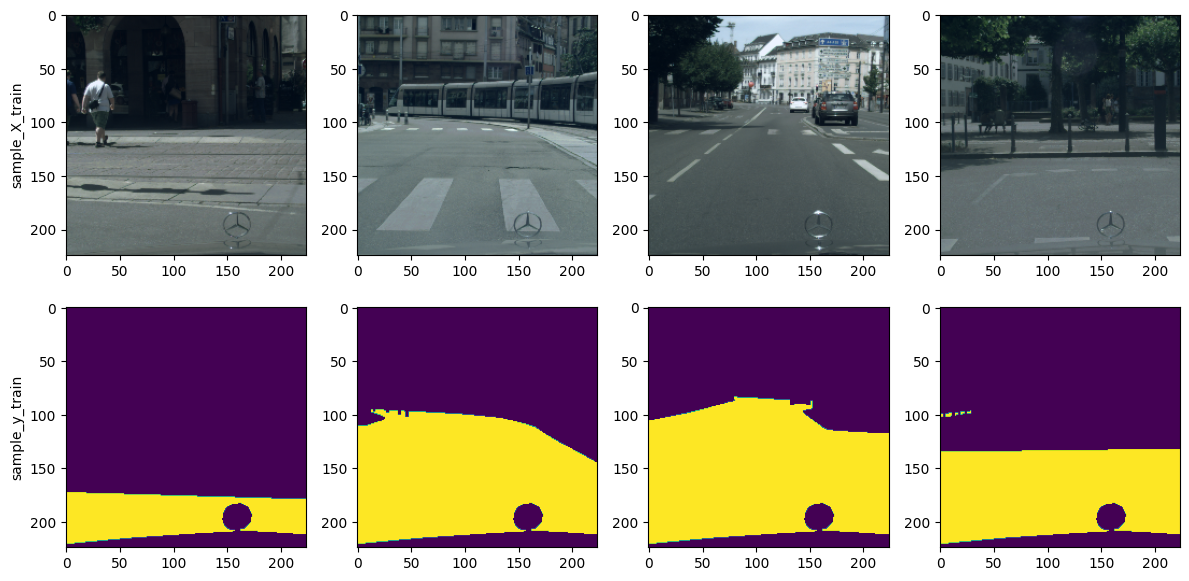

In [11]:
ncols, nrows = 4, 2
fig, subs = plt.subplots(ncols = ncols, nrows = nrows, figsize = (3 * ncols, 3 * nrows))
for i in range(ncols):
    img0 = sample_X_train[i].permute(1, 2, 0)
    img1 = sample_y_train[i].permute(1, 2, 0)[:, :, -1]
    
    subs[0, i].imshow((img0 - img0.min()) / (img0.max() - img0.min()))
    subs[0, 0].set_ylabel('sample_X_train')
    
    subs[1, i].imshow(img1)
    subs[1, 0].set_ylabel('sample_y_train')
    
plt.tight_layout()
plt.show()

In [12]:
ranges = {'vgg16' : ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))}

class VGGNet(nn.Module):
    def __init__(self, pretrained = True):
        super(VGGNet, self).__init__()
        self.ranges   = ranges['vgg16']
        self.features = tv.models.vgg16(weights = pretrained).features
        
    def forward(self, x):
        output = {}
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]): x = self.features[layer](x)
            output['x%d'%(idx + 1)] = x
        
        return output
    

class FCN(nn.Module):
    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.pretrained_net = pretrained_net
        self.n_class        = n_class
        self.relu       = nn.ReLU(inplace = True)
        self.deconv1    = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.bn1        = nn.BatchNorm2d(512)
        self.deconv2    = nn.ConvTranspose2d(512, 256, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.bn2        = nn.BatchNorm2d(256)
        self.deconv3    = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.bn3        = nn.BatchNorm2d(128)
        self.deconv4    = nn.ConvTranspose2d(128,  64, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.bn4        = nn.BatchNorm2d(64)
        self.deconv5    = nn.ConvTranspose2d( 64,  32, kernel_size = 3, stride = 2, padding = 1, dilation = 1, output_padding = 1)
        self.bn5        = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size = 1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x1 = output['x1']  # size = (N,  64, x.H/ 2, x.W/ 2)
        x2 = output['x2']  # size = (N, 128, x.H/ 4, x.W/ 4)
        x3 = output['x3']  # size = (N, 256, x.H/ 8, x.W/ 8)
        x4 = output['x4']  # size = (N, 512, x.H/16, x.W/16)
        x5 = output['x5']  # size = (N, 512, x.H/32, x.W/32)
        
        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
    
        return score  # size=(N, n_class, x.H/1, x.W/1)

vgg16 = VGGNet(pretrained = True)
model = FCN(pretrained_net = vgg16, n_class = NUM_CLASS)

print(model)

C:\Users\BEGAS_15\PycharmProjects\DATA_SCIENCE\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FCN(
  (pretrained_net): VGGNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

In [13]:
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0002)
cross_entropy = torch.nn.CrossEntropyLoss()
dice_metric = monai.metrics.DiceMetric(include_background = False, reduction = 'mean')

def train(model, data_loader, optimizer):
    since = time.time()
    model.train() # 훈련 가능하도록 설정
    epoch_loss = 0
    for batch_idx, (data, label) in tqdm(enumerate(data_loader), total = len(data_loader), desc = 'TRAIN'):
        step = batch_idx + 1
        data, label = data.to(DEVICE), label.to(DEVICE)
        optimizer.zero_grad() # gradient를 새로 계산하기 위해서 0으로 설정
        output = model(data)
        loss = cross_entropy(output, label) # 평균값으로 계산
        loss.backward() # 모델의 모든 매개변수의 grad 속성에 gradient를 게산해서 저장
        optimizer.step() # gradient decent 시작. grad 속성에 저장된 gradient에 따라 각 매개변수를 조정
        epoch_loss += loss.item()
        dice_output = torch.where(output >= 0.5, 1, 0)
        dice_metric(y_pred = dice_output, y = label) # compute metric for current iteration
        
    epoch_loss /= step
    dice_score = dice_metric.aggregate().item() # aggregate the final mean dice result
    dice_metric.reset() # reset the status for next validation round

    time_elapsed = time.time() - since
    
    print(f'Training complete in {time_elapsed // 60 : .0f}m {time_elapsed % 60 : .0f}s')
    
    return epoch_loss, dice_score


def evaluate(model, data_loader):
    model.eval() # 평가 모드로 설정
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, label) in tqdm(enumerate(data_loader), total = len(data_loader), desc = 'VAL'):
            step = batch_idx + 1
            data, label = data.to(DEVICE), label.to(DEVICE)
            output = model(data)
            
            loss += cross_entropy(output, label).item() # 평균값으로 계산됨.
            dice_output = torch.where(output >= 0.5, 1, 0)
            dice_metric(y_pred = dice_output, y = label) # compute metric for current iteration
            
    loss /= len(val_dataset) # 전체 데이터셋의 길이
    dice_score = dice_metric.aggregate().item() # aggregate the final mean dice result
    dice_metric.reset() # reset the status for next validation round
    
    return loss, dice_score

In [14]:
losses = {'train' : [], 'val' : []}
dice_scores = {'train' : [], 'val' : []}
best_metric, best_epoch = 999, -1

for epoch in range(1, EPOCHS + 1):
    train_loss, train_dice_score = train(model, train_loader, optimizer)
    val_loss, val_dice_score = evaluate(model, val_loader)
    
    losses['train'].append(train_loss)
    losses['val'].append(val_loss)
    dice_scores['train'].append(train_dice_score)
    dice_scores['val'].append(val_dice_score)

    print(f'[{epoch}] Train Loss : {train_loss : .6f}, Dice Score : {train_dice_score : .6f}')
    print(f'[{epoch}]  Test Loss : {  val_loss : .6f}, Dice Score : {  val_dice_score : .6f}')
    
    if losses['val'][-1] < best_metric:
        best_metric = losses['val'][-1]
        best_epoch = epoch
        if MODEL_SAVE:
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            
            print('Saved Model')

TRAIN: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:10<00:00,  1.30it/s]


Training complete in  1m  11s


VAL: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:57<00:00,  4.68it/s]


[1] Train Loss :  0.413657, Dice Score :  0.746008
[1]  Test Loss :  0.366438, Dice Score :  0.823646
Saved Model


TRAIN: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:09<00:00,  1.33it/s]


Training complete in  1m  9s


VAL: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:56<00:00,  4.74it/s]


[2] Train Loss :  0.244028, Dice Score :  0.849165
[2]  Test Loss :  0.309891, Dice Score :  0.771978
Saved Model


TRAIN: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:08<00:00,  1.34it/s]


Training complete in  1m  8s


VAL: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:55<00:00,  4.83it/s]


[3] Train Loss :  0.175320, Dice Score :  0.903772
[3]  Test Loss :  0.388534, Dice Score :  0.617196


TRAIN: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:08<00:00,  1.34it/s]


Training complete in  1m  8s


VAL: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:56<00:00,  4.74it/s]


[4] Train Loss :  0.139061, Dice Score :  0.926527
[4]  Test Loss :  0.196408, Dice Score :  0.878858
Saved Model


TRAIN: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:09<00:00,  1.33it/s]


Training complete in  1m  9s


VAL: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:57<00:00,  4.67it/s]


[5] Train Loss :  0.128101, Dice Score :  0.930477
[5]  Test Loss :  0.234441, Dice Score :  0.832502


TRAIN: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:07<00:00,  1.35it/s]


Training complete in  1m  8s


VAL: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:55<00:00,  4.82it/s]


[6] Train Loss :  0.113750, Dice Score :  0.938623
[6]  Test Loss :  0.104207, Dice Score :  0.945657
Saved Model


TRAIN: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:09<00:00,  1.32it/s]


Training complete in  1m  10s


VAL: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:53<00:00,  4.97it/s]


[7] Train Loss :  0.103772, Dice Score :  0.943987
[7]  Test Loss :  0.124719, Dice Score :  0.926128


TRAIN: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:05<00:00,  1.40it/s]


Training complete in  1m  6s


VAL: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:54<00:00,  4.86it/s]


[8] Train Loss :  0.096185, Dice Score :  0.947894
[8]  Test Loss :  0.158722, Dice Score :  0.891038


TRAIN: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:08<00:00,  1.35it/s]


Training complete in  1m  8s


VAL: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:57<00:00,  4.66it/s]


[9] Train Loss :  0.102619, Dice Score :  0.945973
[9]  Test Loss :  0.115266, Dice Score :  0.926921


TRAIN: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:09<00:00,  1.33it/s]


Training complete in  1m  9s


VAL: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [00:58<00:00,  4.57it/s]

[10] Train Loss :  0.104087, Dice Score :  0.943981
[10]  Test Loss :  0.156549, Dice Score :  0.931665


In [16]:
print(f"Train completed, best_metric: {best_metric:.4f} \n" 
      f"At epoch: {best_epoch}")

Train completed, best_metric: 0.1042 
At epoch: 6


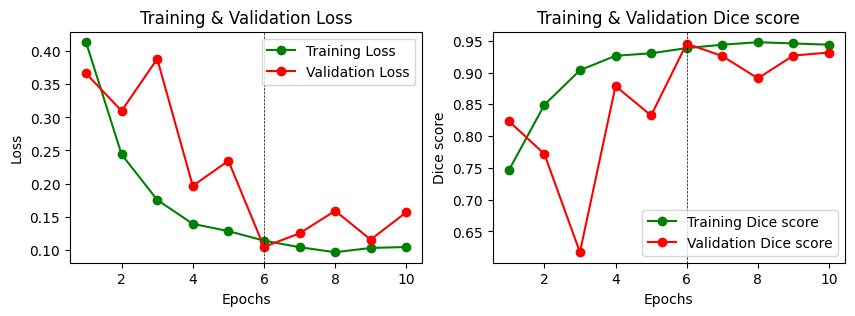

In [24]:
epochs = [i + 1 for i in range(len(losses['train']))]
train_loss = losses['train']
val_loss = losses['val']
train_dice = dice_scores['train']
val_dice = dice_scores['val']

fig, subs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 3))

subs[0].plot(epochs, train_loss, 'g-o', label =   'Training Loss')
subs[0].plot(epochs,   val_loss, 'r-o', label = 'Validation Loss')
subs[0].set_title('Training & Validation Loss')
subs[0].legend()
subs[0].set_xlabel("Epochs")
subs[0].set_ylabel("Loss")
subs[0].axvline(best_epoch, c = 'k', ls = '--', lw = .5)

subs[1].plot(epochs, train_dice, 'go-', label =   'Training Dice score')
subs[1].plot(epochs,   val_dice, 'ro-', label = 'Validation Dice score')
subs[1].set_title('Training & Validation Dice score')
subs[1].legend()
subs[1].set_xlabel("Epochs")
subs[1].set_ylabel("Dice score")
subs[1].axvline(best_epoch, c = 'k', ls = '--', lw = .5)

plt.show()

In [27]:
pred_dict = {'input' : [], 'output' : []}

if MODEL_SAVE: model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.to('cpu')
model.eval()
with torch.no_grad():
    for i, (data, _) in tqdm(enumerate(test_loader), total = len(test_loader), desc = 'TEST'):
        data = data.to('cpu')
        output = model(data).detach().cpu()
        output = torch.argmax(output, dim = 1, keepdim = True)
        
        data_   =   data[0].permute(1, 2, 0)        
        output_ = output[0].permute(1, 2, 0)[:, :, -1]
        
        pred_dict[ 'input'].append(  data_)
        pred_dict['output'].append(output_)

TEST: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 544/544 [03:13<00:00,  2.81it/s]


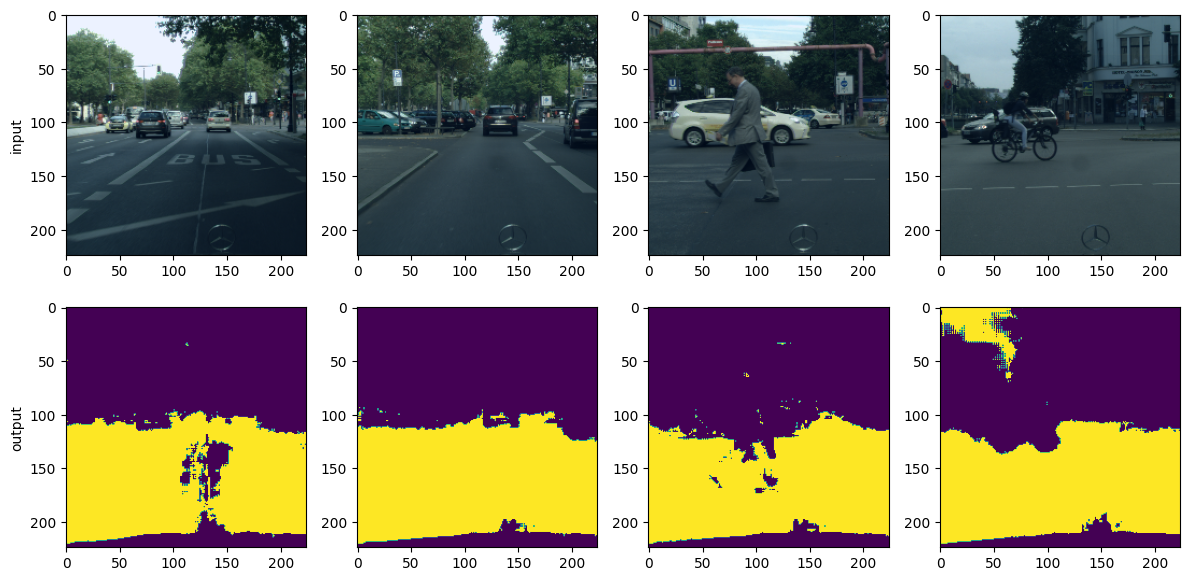

In [32]:
ncols, nrows = 4, 2
fig, subs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3 * ncols, 3 * nrows))
for i in range(ncols):
    img0 = pred_dict['input'][i]
    subs[0, i].imshow((img0 - img0.min()) / (img0.max() - img0.min()))
    subs[0, 0].set_ylabel('input')
    
    subs[1, i].imshow(pred_dict['output'][i])
    subs[1, 0].set_ylabel('output')
plt.tight_layout()

plt.show()